In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score


In [4]:
# Carregar os arquivos CSV
train_df = pd.read_csv('/Users/lucastourinho/TitanicSurvivalProbability/data/train.csv')
test_df = pd.read_csv('/Users/lucastourinho/TitanicSurvivalProbability/data/test.csv')
gender_submission_df = pd.read_csv('/Users/lucastourinho/TitanicSurvivalProbability/data/gender_submission.csv')

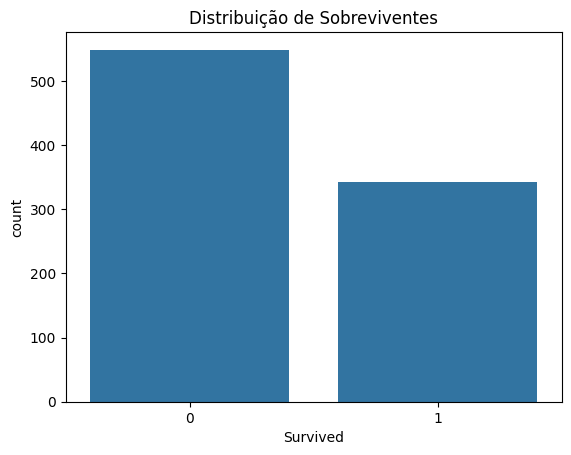

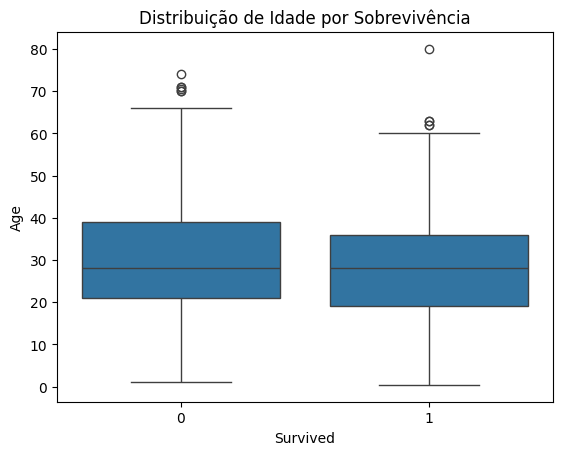

In [14]:
# Gráfico da distribuição de sobreviventes
sns.countplot(data=train_df, x='Survived')
plt.title("Distribuição de Sobreviventes")
plt.show()

# Gráfico da distribuição de idade por classe de sobrevivência
sns.boxplot(data=train_df, x='Survived', y='Age')
plt.title("Distribuição de Idade por Sobrevivência")
plt.show()

In [5]:
# Visualizar colunas relevantes do dataset de treino
# O dataset de treino contém a variável 'Survived' que vamos prever
print(train_df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [6]:
# Pré-processamento de dados
def preprocess_data(df):
    # Manter apenas as colunas relevantes
    df = df[['Pclass', 'Sex', 'Age', 'Fare']].copy()
    
    # Tratar valores faltantes
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Fare'].fillna(df['Fare'].mean(), inplace=True)
    
    # Converter a coluna 'Sex' para numérico
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    
    return df

# Pré-processar os dados de treino e teste
X_train = preprocess_data(train_df)
y_train = train_df['Survived']
X_test = preprocess_data(test_df)

In [7]:
# Treinamento dos modelos
classifiers = [
    ("Random Forest", RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42))
]

In [9]:
# Aplicar os classificadores
for name, clf in classifiers:
    # Normalizar os dados e treinar o modelo
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    clf.fit(X_train_scaled, y_train)
    
    # Fazer previsões no conjunto de teste
    predictions = clf.predict(X_test_scaled)
    
    # Avaliar precisão comparando com gender_submission.csv
    submission = gender_submission_df['Survived']
    accuracy = accuracy_score(submission, predictions)
    
    print(f"Modelo: {name} - Acurácia: {accuracy:.4f}")

Modelo: Random Forest - Acurácia: 0.9163
Modelo: Logistic Regression - Acurácia: 0.9641


In [10]:
# Treinamento dos modelos individuais
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

# Criar o ensemble com VotingClassifier
ensemble_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('lr', lr_clf)], voting='soft'
)

# Normalizar os dados de treino e teste
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Treinar o ensemble
ensemble_clf.fit(X_train_scaled, y_train)

# Fazer previsões usando o ensemble
ensemble_predictions = ensemble_clf.predict(X_test_scaled)

# Avaliar precisão do ensemble comparando com gender_submission.csv
ensemble_accuracy = accuracy_score(gender_submission_df['Survived'], ensemble_predictions)

print(f"Modelo Ensemble - Acurácia: {ensemble_accuracy:.4f}")


Modelo Ensemble - Acurácia: 0.9545


Relatório de Classificação do Ensemble:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       266
           1       0.96      0.91      0.94       152

    accuracy                           0.95       418
   macro avg       0.96      0.95      0.95       418
weighted avg       0.95      0.95      0.95       418



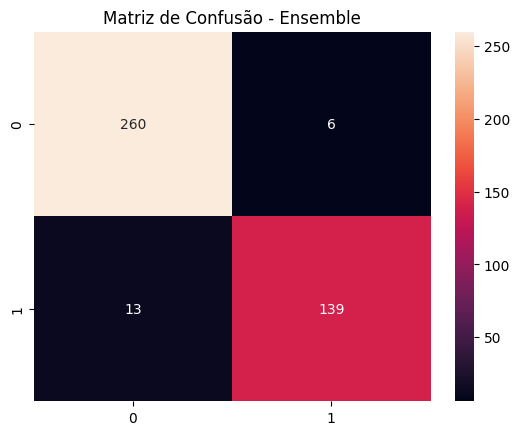

In [15]:
# Avaliar o modelo ensemble
print("Relatório de Classificação do Ensemble:")
print(classification_report(gender_submission_df['Survived'], ensemble_predictions))

# Matriz de confusão
cm = confusion_matrix(gender_submission_df['Survived'], ensemble_predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Matriz de Confusão - Ensemble')
plt.show()

In [16]:
# Cross-Validation

scores = cross_val_score(ensemble_clf, X_train_scaled, y_train, cv=5)
print(f"Acurácia média na validação cruzada: {scores.mean():.4f}")

Acurácia média na validação cruzada: 0.8081


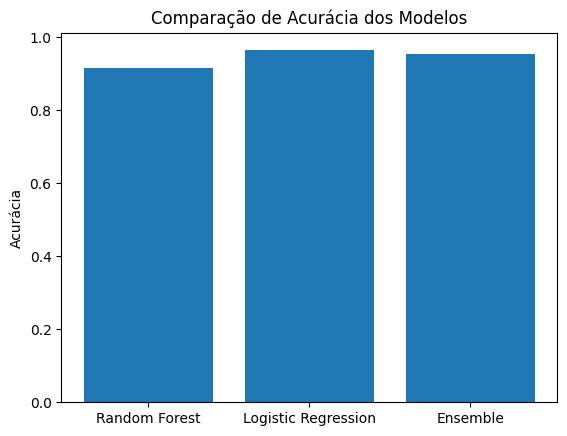

In [17]:
model_names = ['Random Forest', 'Logistic Regression', 'Ensemble']
accuracies = [0.9163, 0.9641, ensemble_accuracy]

plt.bar(model_names, accuracies)
plt.title('Comparação de Acurácia dos Modelos')
plt.ylabel('Acurácia')
plt.show()